In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

# A Comparison of Bandit Algorithms

We've now taken a look at some of the main algorithms used to tackle the multi-armed Bandit problem (although we've only just scratched the surface in terms of looking at all available algorithms, take a look at the __[Bandit Book](https://medium.com/r/?url=https%3A%2F%2Ftor-lattimore.com%2Fdownloads%2Fbook%2Fbook.pdf)__ if you'd like to see a whole lot more). The one question left to be answered is, which is best? Or, in other words, which algorithm will let Baby Robot get fully charged in the shortest amount of time?

Restricting our experiment slightly further, and specifying the condition that Baby Robot has a maximum charge capacity of 3600 seconds worth of charge, which algorithm can get him to this limit the quickest?

For completeness we once again show all of the different Power Sockets that we'll be testing...

### The Standard Power Socket

In [2]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q):                
        self.q = q        # the true reward value              
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R
    
    def sample(self,t):
        """ return an estimate of the socket's reward value """
        return self.Q

### The Optimistic Greedy Power Socket

In [3]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):    
                      
        # get the initial reqrd estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.) 
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
                
    def initialize(self):        
        # estimate of this socket's reward value 
        # - set to supplied initial value
        self.Q = self.initial_estimate    
        self.n = 0    

### The Upper Confidence Bounds Socket

In [4]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):    
        """ initialize the UCB socket """                  
        
        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)        
                
        # pass the true reward value to the base PowerSocket   
        super().__init__(q)           
        
    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

### The Gaussian Thompson Sampling Socket

In [5]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self, q):                
                
        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
        
    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0    
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """   

        # do a standard update of the estimated mean
        super().update(R)    
               
        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)        
        self.τ_0 += 1       

### The Epsilon Greedy Socket Tester

Note that Epsilon Greedy just uses the standard power socket. Instead of cusomizing the power socket class it instead modifies the socket selection algorithm, to randomly select from the complete set of sockets when the probability value is less than the defined value of epsilon.

All other algorithms just use the standard socket selection routine, which always chooses the socket that returns the highest reward on the current time-step.

In [6]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, multiplier=2, epsilon = 0.2 ):  
        
        # create a standard socket tester
        super().__init__(socket_order=socket_order, multiplier=multiplier) 
        
        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon
    
    
    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""
        
        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie            
            socket_index = random_argmax([socket.sample() for socket in self.sockets])               
        
        return socket_index

## Testing on the standard power socket problem

Baby Robot has found himself in a charging room with 5 power sockets. Each of these has a unique mean power output with unit variance. By definition Baby Robot can take a maximum of 3600 seconds worth of charge. Let's find which algorithm can get him to this the quickest...

In [7]:
def run_single_test( tester ):
    """ run one test using the supplied socket tester """
    
    steps, total_reward = tester.run( number_of_steps = 500, maximum_total_reward = 3600 )

    print(f'Mean Reward per Time Step = {tester.get_mean_reward():0.3f}')
    print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
    print(f'Socket Percentages = {tester.get_socket_percentages()}') 

    if total_reward < 3600:
        print(f'Target total reward not achieved - reward = {total_reward}')
    else:
        print(f'Target total reward achieved in {steps} time-steps')    

In [8]:
# Greedy Selection
run_single_test( SocketTester( PowerSocket ) )

Mean Reward per Time Step = 4.051
Optimal Socket Selected = 0.000
Socket Percentages = [0.000 1.000 0.000 0.000 0.000]
Target total reward not achieved - reward = 2021.376003086628


In [9]:
# Epsilon Greedy
run_single_test( EpsilonGreedySocketTester( epsilon = 0.2 ) )

Mean Reward per Time Step = 10.962
Optimal Socket Selected = 0.805
Socket Percentages = [0.061 0.058 0.049 0.805 0.027]
Target total reward achieved in 329 time-steps


In [10]:
# Optimistic Greedy
run_single_test( SocketTester( OptimisticSocket, initial_estimate = 20. ))

Mean Reward per Time Step = 11.986
Optimal Socket Selected = 0.987
Socket Percentages = [0.003 0.003 0.003 0.987 0.003]
Target total reward achieved in 301 time-steps


In [11]:
# UCB
run_single_test( SocketTester( UCBSocket, confidence_level = 0.6 ))

Mean Reward per Time Step = 12.061
Optimal Socket Selected = 0.987
Socket Percentages = [0.003 0.003 0.003 0.987 0.003]
Target total reward achieved in 299 time-steps


In [12]:
# Thompson Sampling
run_single_test( SocketTester( GaussianThompsonSocket ))

Mean Reward per Time Step = 12.042
Optimal Socket Selected = 0.980
Socket Percentages = [0.003 0.003 0.003 0.980 0.010]
Target total reward achieved in 299 time-steps


### Running for multiple tests

In [13]:
rewards = []

def run_multiple_tests( tester, max_steps = 500 ):
    number_of_tests = 100
    number_of_steps = max_steps
    maximum_total_reward = 3600

    experiment = SocketExperiment(socket_tester   = tester,
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps,
                                  maximum_total_reward = maximum_total_reward)
    experiment.run()

    print(f'Mean Reward per Time Step = {experiment.get_mean_total_reward():0.3f}')
    print(f'Optimal Socket Selected = {experiment.get_optimal_selected():0.3f}')
    print(f'Socket Percentages = {experiment.get_socket_percentages()}') 
    print(f'Average Number of Trials Per Run = {experiment.get_mean_time_steps():0.3f}')
    
    rewards.append( experiment.get_cumulative_reward_per_timestep() )        

In [14]:
# Greedy Selection
run_multiple_tests( SocketTester( PowerSocket ) )

Mean Reward per Time Step = 8.103
Optimal Socket Selected = 0.180
Socket Percentages = [0.200 0.190 0.170 0.180 0.260]
Average Number of Trials Per Run = 418.460


In [15]:
# Epsilon Greedy
run_multiple_tests( EpsilonGreedySocketTester( epsilon = 0.2 ) )

Mean Reward per Time Step = 11.085
Optimal Socket Selected = 0.793
Socket Percentages = [0.044 0.045 0.051 0.793 0.068]
Average Number of Trials Per Run = 325.370


In [16]:
# Optimistic Greedy
run_multiple_tests( SocketTester( OptimisticSocket, initial_estimate = 20. ))

Mean Reward per Time Step = 11.914
Optimal Socket Selected = 0.957
Socket Percentages = [0.003 0.003 0.003 0.957 0.033]
Average Number of Trials Per Run = 302.920


In [17]:
# UCB
run_multiple_tests( SocketTester( UCBSocket, confidence_level = 0.6 ))

Mean Reward per Time Step = 11.971
Optimal Socket Selected = 0.985
Socket Percentages = [0.003 0.003 0.003 0.985 0.005]
Average Number of Trials Per Run = 301.220


In [18]:
# Thompson Sampling
run_multiple_tests( SocketTester( GaussianThompsonSocket ))

Mean Reward per Time Step = 12.046
Optimal Socket Selected = 1.000
Socket Percentages = [0.000 0.000 0.000 1.000 0.000]
Average Number of Trials Per Run = 299.370


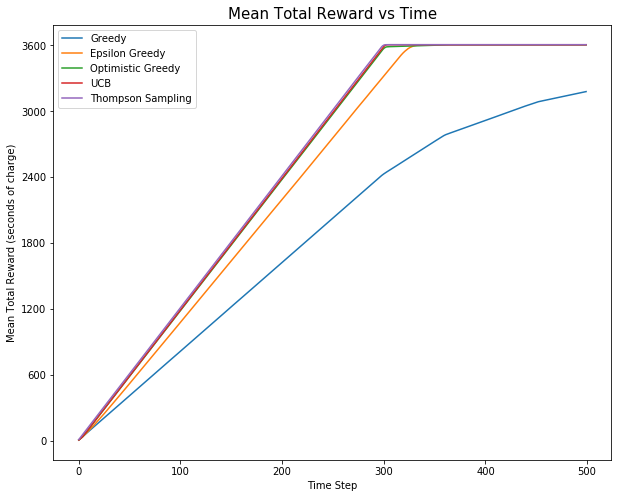

In [19]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

plt.savefig("algorithm_comparison.png")

From the graph above we can see that:

* Optimistic Greedy, UCB and Thompson Sampling all reach the maximum required charge in approximately the same number of time steps and that, in each case, the regret is nearly zero. Each has taken only 300 time steps to reach the maximum required charge of 3600 seconds of charge, when the maximum available charge from any socket is 12 seconds of charge. So the optimal socket has been located quickly and then exploited to the full.
* Epsilon Greedy on the other hand takes slightly longer to reach maximum charge. Since it continues to explore the set of sockets throughout the run it fails to fully exploit the best socket.
* And worst of all is the Greedy algorithm. It actually fails to reach the maximum charge in the time available.

So, from the point of view of charging Baby Robot, any of the Optimistic Greedy, UCB or Thompson Sampling algorithms would do the job. However, it should be noted that both Optimistic Greedy and UCB require a parameter to be set and making a bad choice for this parameter could lead to a degraded performance of the algorithm. Since Thompson Sampling doesn't require a parameter to be set, this isn't an issue and so may be the deciding factor when choosing which algorithm to use.

## Making things harder

The socket problem we've used up to now was deliberately made very simple, to allow the  exploration and exploitation mechanisms of each algorithm to be illustrated. However, in terms of finding which algorithm is best, it has a couple of major drawbacks.

Firstly, it only has a five sockets. Therefore, even with the random search of the Greedy algorithm, there's a 20% chance of finding the best socket and for the algorithms with more advanced search mechanisms, they don't have to test many sockets before they can locate the best one.

Secondly, each socket has a very distinct reward. Since we setup the experiment with the sockets having a spacing of 2 seconds of charge and a unit variance in their reward, there is very little overlap in the amount of charge returned by a socket and the next best socket. Once the best socket has been tried once, it is very unlikely that any of the other sockets will return a charge that is greater than this value, making it very easy to identify which socket is optimal.

To overcome these deficiencies in our original experiment, let's double the number of sockets and decrease the difference in the amount of charge the sockets can return, reducing this from 2 seconds of charge down to 0.2. With these values the output of the sockets now looks as follows:

In [20]:
NUM_SOCKETS = 10

# using a fixed ordering for consistency
socket_order = [7, 5, 1, 10, 2, 3, 6, 8, 9, 4]

print(f"Socket Order: {socket_order}")

MULTIPLIER = 0.2

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give 
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*MULTIPLIER)+2) for q in socket_order]

# iterate through each of the sockets
# - rewards will contain the charge returned at all of the time steps for each socket 
# - using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))
for socket_number,socket in enumerate(sockets):    
    # get charge from the socket for the defined number of steps   
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()        

Socket Order: [7, 5, 1, 10, 2, 3, 6, 8, 9, 4]


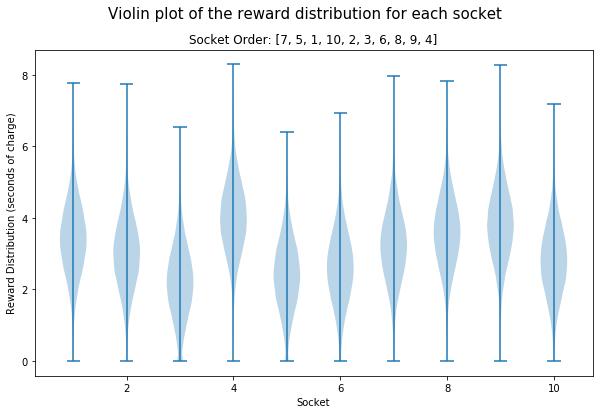

In [21]:
# plot the charge we got from the sockets    
plt.figure(figsize=(10,6))
plt.violinplot(rewards)   
plt.suptitle('Violin plot of the reward distribution for each socket', fontsize=15)
plt.title(f'Socket Order: {socket_order}')
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)') 
plt.savefig('violin_plot_10sockets.png')
plt.show() 

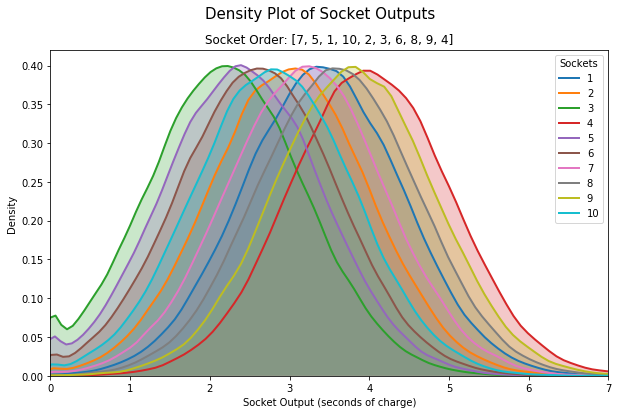

In [22]:
plt.figure(figsize=(10,6))

for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');
    
# Plot formatting
plt.xlim(0, 7)
plt.legend(title = 'Sockets')
plt.suptitle('Density Plot of Socket Outputs', fontsize=15)
plt.title(f'Socket Order: {socket_order}')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')
plt.savefig("density_plot_10sockets.png")

Now we have 10 sockets, with 0.2 seconds of charge difference between the mean reward of a socket and the next best, meaning that there's a much greater overlap in the rewards that are returned. 

The socket order [7, 5, 1, 10, 2, 3, 6, 8, 9, 4] defines how good a socket is, in increasing order, so socket number 1 is the 7th best socket and will have a mean reward of (7*0.2 +2) = 3.4 seconds of charge (the +2 is just an offset value to stop sockets from having negative values). So the best socket is socket 4, having a mean reward of (10*0.2 +2) = 4 and the worst is socket 3, with a mean reward of (1*0.2 +2) = 2.2.

A couple of other points to note are:

* Because we've reduced the spread in the mean values of the sockets, that the best socket now has a lower output that when we only tested with 5 sockets. As a result, the number of time steps required to reach our defined maximum total reward, of 3600 seconds of charge, will be increased.

* We've kept the parameters the same for the UCB and Optimistic Greedy algorithms as in the 5 socket experiment, so it's possible that tuning these values may give better results.

In [23]:
rewards = []

def run_tests( tester, max_steps = 1000 ): 
    run_multiple_tests( tester, max_steps = max_steps )

In [24]:
# Greedy Selection
run_tests( SocketTester( PowerSocket, socket_order, multiplier = MULTIPLIER ) )

Mean Reward per Time Step = 3.100
Optimal Socket Selected = 0.140
Socket Percentages = [0.110 0.110 0.110 0.140 0.080 0.080 0.050 0.120 0.040 0.160]
Average Number of Trials Per Run = 982.970


In [25]:
# Epsilon Greedy
run_tests( EpsilonGreedySocketTester( socket_order, multiplier = MULTIPLIER, epsilon = 0.2 ))

Mean Reward per Time Step = 3.769
Optimal Socket Selected = 0.634
Socket Percentages = [0.028 0.022 0.021 0.634 0.020 0.020 0.024 0.046 0.162 0.023]
Average Number of Trials Per Run = 955.850


In [26]:
# Optimistic Greedy
run_tests( SocketTester( OptimisticSocket, socket_order, multiplier = MULTIPLIER, initial_estimate = 20. ))

Mean Reward per Time Step = 3.864
Optimal Socket Selected = 0.584
Socket Percentages = [0.023 0.003 0.001 0.584 0.001 0.001 0.022 0.125 0.238 0.002]
Average Number of Trials Per Run = 930.440


In [27]:
# UCB
run_tests( SocketTester( UCBSocket, socket_order, multiplier = MULTIPLIER, confidence_level = 0.6 ))

Mean Reward per Time Step = 3.930
Optimal Socket Selected = 0.741
Socket Percentages = [0.009 0.004 0.002 0.741 0.002 0.002 0.004 0.020 0.213 0.003]
Average Number of Trials Per Run = 916.950


In [28]:
# Thompson Sampling
run_tests( SocketTester( GaussianThompsonSocket, socket_order, multiplier = MULTIPLIER ))

Mean Reward per Time Step = 4.005
Optimal Socket Selected = 0.990
Socket Percentages = [0.001 0.000 0.000 0.990 0.000 0.000 0.001 0.000 0.007 0.000]
Average Number of Trials Per Run = 899.400


Running with this new setup generates the following results:

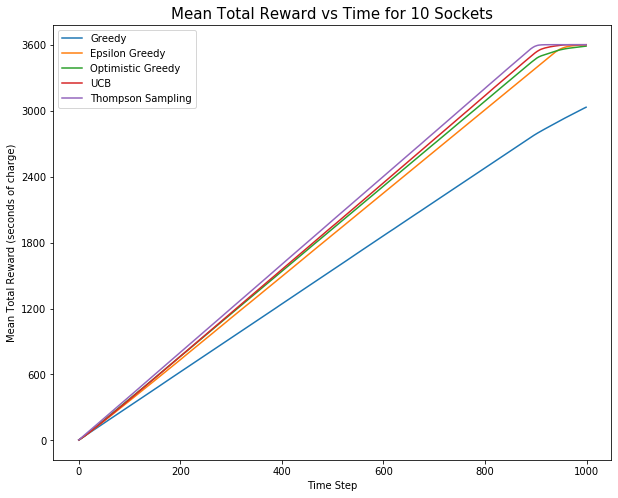

In [29]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time for 10 Sockets', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

plt.savefig("algorithm_comparison_10_sockets.png")

Now we can see some separation in the performance of the algorithms: 

* As before, the Greedy algorithm performs much worse than all the others and Epsilon Greedy, while being much better than the simple Greedy algorithm, is still worse than the other 3 algorithms.

* Although there's not a lot in it, Thompson Sampling clearly outperforms the others. This difference becomes more distinct as the number of sockets is increased and the spread of mean reward values is decreased, as shown below, for 100 sockets with a spread of 0.1:

In [30]:
# create the specified number of sockets in a random order 
NUM_SOCKETS = 100
socket_order = random.sample(range(1,1+NUM_SOCKETS), NUM_SOCKETS)

MULTIPLIER = 0.1

rewards = []

def run_tests( tester, max_steps = 300 ): 
    run_multiple_tests( tester, max_steps = max_steps )
    
run_tests( SocketTester( PowerSocket, socket_order, multiplier = MULTIPLIER ) )    
run_tests( EpsilonGreedySocketTester( socket_order, multiplier = MULTIPLIER, epsilon = 0.2 ))
run_tests( SocketTester( OptimisticSocket, socket_order, multiplier = MULTIPLIER, initial_estimate = 20. ))
run_tests( SocketTester( UCBSocket, socket_order, multiplier = MULTIPLIER, confidence_level = 0.6 ))
run_tests( SocketTester( GaussianThompsonSocket, socket_order, multiplier = MULTIPLIER ))

Mean Reward per Time Step = 6.648
Optimal Socket Selected = 0.010
Socket Percentages = [0.010 0.020 0.010 0.010 0.020 0.020 0.000 0.000 0.010 0.000 0.010 0.010
 0.020 0.010 0.030 0.010 0.000 0.020 0.020 0.000 0.020 0.000 0.010 0.010
 0.000 0.010 0.020 0.000 0.010 0.030 0.000 0.000 0.010 0.030 0.030 0.020
 0.010 0.000 0.000 0.030 0.010 0.010 0.020 0.010 0.020 0.000 0.000 0.020
 0.020 0.010 0.000 0.010 0.000 0.030 0.010 0.010 0.000 0.000 0.000 0.030
 0.000 0.010 0.010 0.000 0.000 0.010 0.010 0.010 0.000 0.010 0.010 0.030
 0.010 0.010 0.010 0.000 0.010 0.000 0.010 0.010 0.020 0.000 0.000 0.020
 0.020 0.000 0.010 0.020 0.000 0.000 0.010 0.000 0.010 0.000 0.000 0.000
 0.010 0.010 0.030 0.000]
Average Number of Trials Per Run = 298.990
Mean Reward per Time Step = 10.492
Optimal Socket Selected = 0.002
Socket Percentages = [0.003 0.003 0.002 0.003 0.002 0.002 0.029 0.002 0.002 0.004 0.002 0.002
 0.002 0.002 0.004 0.002 0.002 0.003 0.021 0.002 0.002 0.004 0.004 0.003
 0.004 0.007 0.002 0.023 0

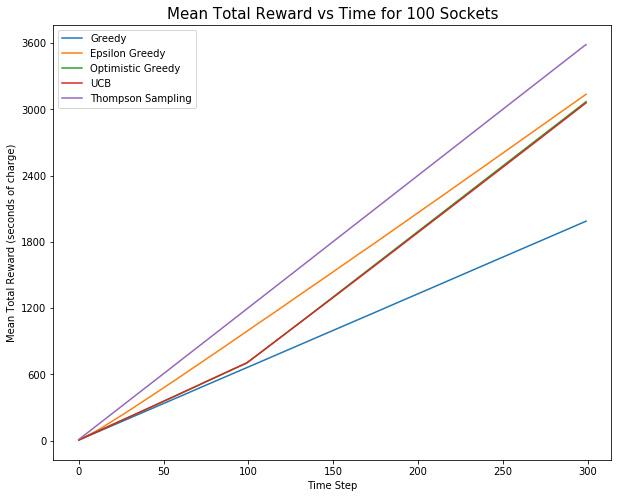

In [31]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')
    
plt.legend()    
plt.title('Mean Total Reward vs Time for 100 Sockets', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

plt.savefig("algorithm_comparison_100_sockets.png")